In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from tqdm.notebook import tqdm

In [2]:
# THIS IS ADITYA'S CODE
def rotation_matrix(axis: torch.Tensor, theta: torch.Tensor, homogeneous: bool = False) -> torch.Tensor:
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    #axis = np.asarray(axis)

    # TODO: hacky broadcasting
    theta = theta[..., None]
    axis, theta = torch.broadcast_tensors(axis, theta)
    theta = theta[..., 0] # the last dimension gets broadcasted to "3", so truncate

    axis = axis / torch.norm(axis, 2, dim=-1)[..., None]
    a = torch.cos(theta / 2.0)
    # Transpose so we can unpack into variables
    b, c, d = torch.unbind(-axis * torch.sin(theta / 2.0)[..., None], dim=-1)

    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    mat =  torch.stack([torch.stack([aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)], dim=-1),
                        torch.stack([2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)], dim=-1),
                        torch.stack([2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc], dim=-1)],
                       dim=-2)

    if not homogeneous:
        return mat

    extra_dims = axis.shape[:-1]
    zeros_column = torch.zeros_like(mat)[..., :, 0:1] # shape: (..., 3, 1)
    hstacked = torch.cat([mat, zeros_column], dim=-1) # shape: (..., 3, 4)

    hom_row = torch.cat((torch.zeros_like(hstacked)[..., :1, :3],
                         torch.ones_like(hstacked)[..., :1, 3:]), dim=-1) # shape: (..., 1, 4)
    return torch.cat((hstacked, hom_row), dim=-2)

def translation_matrix(tvec: torch.Tensor) -> torch.Tensor:
    extra_dims = tvec.shape[:-1]
    eye_tiled = torch.eye(3, dtype=tvec.dtype).to(tvec.device).repeat(extra_dims + (1, 1))
    hstacked = torch.cat([eye_tiled, tvec[..., :, None]], dim=-1)

    hom_row = torch.cat((torch.zeros_like(hstacked)[..., :1, :3],
                         torch.ones_like(hstacked)[..., :1, 3:]), dim=-1) # shape: (..., 1, 4)
    return torch.cat((hstacked, hom_row), dim=-2)
def dofs2mat(dofs):
    T = dofs[..., :3]
    angle = dofs[..., 3:].norm(dim=-1)
    axis = dofs[..., 3:]/angle[..., None]
    rot_mat = rotation_matrix(axis, angle, homogeneous=True)
    trans_mat = translation_matrix(T)
    return trans_mat @ rot_mat

def to_homo(X, dim=-1):
    X = X.transpose(dim, -1)
    X = torch.cat((X, torch.ones(X.shape[:-1]+(1,))), dim=-1)
    X = X.transpose(dim, -1)
    return X
def from_homo(X, dim=-1):
    X = X.transpose(dim, -1)
    X = X[..., :-1]/X[..., -1, None]
    X = X.transpose(dim, -1)
    return X

In [3]:
f = 1.
m_x, m_y = 1., 1.
u_0, v_0 = 0., 0.

rest_dofs = torch.zeros(6)
rest_dofs[3] = 2*np.pi

In [4]:
def project_to_cam(X_w, dofs_cam=rest_dofs, f=f, m=(m_x, m_y), uv=(u_0, v_0), ret_vis_mask=False):
    
    X_w = to_homo(X_w)
    X_c = (dofs2mat(dofs_cam) @ (X_w[..., None]))[..., 0]
    vis_mask = from_homo(X_c)[..., 2]>0.
    mat_in = torch.tensor([[m[0], 0., uv[0], 0.],
                           [0., m[1], uv[1], 0.],
                           [0., 0., 1., 0.]])
    mat_in *= (torch.tensor([[0., 1., 1., 1.],
                             [1., 0., 1., 1.],
                             [1., 1., 1., 1.]])\
              +f*torch.tensor([[1., 0., 0., 0.],
                             [0., 1., 0., 0.],
                             [0., 0., 0., 0.]]))
    
    X_i = (mat_in@(X_c[..., None]))[..., 0]
    X_i = from_homo(X_i)
    if ret_vis_mask:
        return X_i, vis_mask
    return X_i

In [5]:
dofs_cam = rest_dofs.clone()
dofs_cam[2] = 0
# dofs_cam[3:] = torch.tensor([0., np.pi/7, 0.])

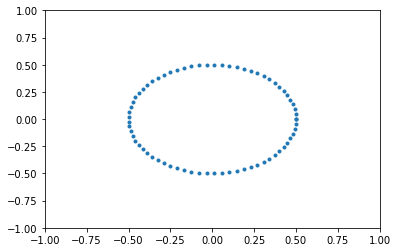

In [6]:
X = torch.cos(torch.linspace(0, 2*np.pi, 70))
Y = torch.sin(torch.linspace(0, 2*np.pi, 70))
Z = 2*torch.ones_like(X)
X_w = torch.stack((X, Y, Z), axis=-1)
X_i = project_to_cam(X_w, dofs_cam)
plt.scatter(X_i[:, 0], X_i[:, 1], marker='.')
plt.xlim(-1, 1);plt.ylim(-1, 1);
plt.show()

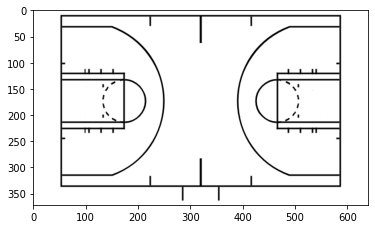

In [7]:
img = plt.imread('/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/court.png')
plt.imshow(img)
plt.show()

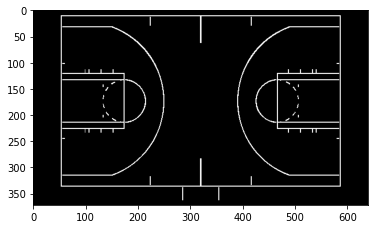

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
binary = gray<0.1
plt.imshow(binary, cmap='gray')
plt.show()

In [9]:
scale = binary.shape[0]
y = (np.arange(binary.shape[0])-binary.shape[0]/2.)/scale
x = (np.arange(binary.shape[1])-binary.shape[1]/2.)/scale
y, x = np.meshgrid(y, x, indexing='ij')
z, x = y[binary], x[binary]
y = np.zeros_like(x)

In [10]:
dofs_cam = rest_dofs.clone()
dofs_cam[:3] = torch.tensor([.5, -0.5, 1.0])
dofs_cam[3:] = torch.tensor([0., np.pi/10, 0.])

In [11]:
def show_cam_view(X_w, dofs_cam=rest_dofs, f=f, m=(m_x, m_y), uv=(u_0, v_0)):
    X_i, vis_mask = project_to_cam(X_w, dofs_cam, f, m, uv, ret_vis_mask=True)
    X_i = X_i[vis_mask]
    plt.figure(figsize=(5, 5*m[1]/m[0]))
    plt.scatter(X_i[:, 0], X_i[:, 1], marker='.')
    plt.xlim(-m[0]+uv[0], m[0]+uv[0]);plt.ylim(-m[1]+uv[1], m[1]+uv[1])
    plt.show()

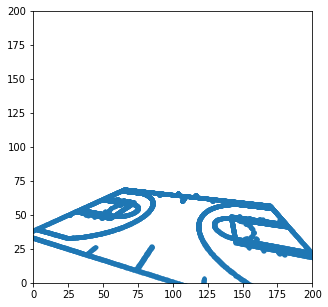

In [12]:
X_w = torch.from_numpy(np.stack((x, y, z), axis=-1)).float()

dofs_cam = rest_dofs.clone()
dofs_cam[:3] = torch.tensor([0., -0.5, 1.0])
dofs_cam[3:] = torch.tensor([0., np.pi/10, 0.])


show_cam_view(X_w, dofs_cam, f, (100., 100.), (100, 100))

In [13]:
X_w = X_w[::10, :]

# Rendering Loss

In [22]:
def smooth_max(x, alpha, dim=-1):
    # unstable version:
    # return (x*(alpha*x).exp()).sum()/((alpha*x).exp()).sum()
    return ((alpha*x).softmax(dim=dim)*x).sum(dim=dim)

In [23]:
def pt2pt_dist(p1, p2):
    # (..., N1, D) and (..., N2, D)
    return (p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1).min(dim=-1).values

def pt2pt_dist_soft(p1, p2, alpha=-1.):
    # (..., N1, D) and (..., N2, D)
    return smooth_max((p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1), alpha=alpha, dim=-1)

In [24]:
dofs_cam_optim = dofs_cam.clone()
f_optim = torch.tensor(f)
torch.manual_seed(10)
dofs_cam_optim+=0.2*torch.randn(dofs_cam_optim.shape)
f_optim+=0.2*torch.randn(1).item()

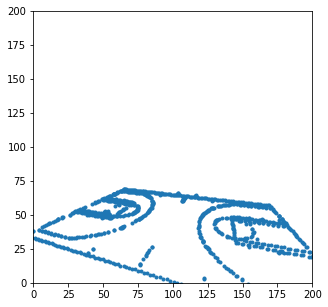

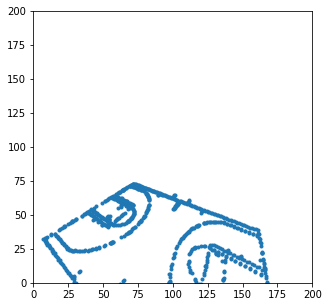

In [25]:
show_cam_view(X_w, dofs_cam, f, (100., 100.), (100, 100))
show_cam_view(X_w, dofs_cam_optim, f_optim, (100., 100.), (100, 100))

In [26]:
opt = torch.optim.Adam([{'params': dofs_cam_optim, 'lr': 0.01},
                        {'params': f_optim, 'lr': 0.005}])
dofs_cam_optim.requires_grad_()
f_optim.requires_grad_()

for _ in tqdm(range(200)):
    X_i, vis_mask = project_to_cam(X_w, dofs_cam_optim, f_optim, (100., 100.), (100, 100), ret_vis_mask=True)
    X_i = X_i[vis_mask]

    X_true, vis_mask = project_to_cam(X_w, dofs_cam, f, (100., 100.), (100, 100), ret_vis_mask=True)
    X_true = X_true[vis_mask]
    
#     loss = pt2pt_dist(X_i, X_true)
    loss = pt2pt_dist_soft(X_i, X_true, alpha=-10)
    loss = loss.mean()
    print('loss: ', loss.item())
    print('pt2pt: ', pt2pt_dist(X_i, X_true).mean().item())
    print(f_optim.item())
    
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    

loss:  15.31882381439209
pt2pt:  15.294657707214355
0.8261640071868896
loss:  13.290276527404785
pt2pt:  13.265551567077637
0.8211640119552612
loss:  11.487119674682617
pt2pt:  11.46186351776123
0.8161802291870117
loss:  9.966792106628418
pt2pt:  9.94200325012207
0.8112909197807312
loss:  8.554816246032715
pt2pt:  8.529751777648926
0.8065123558044434
loss:  7.3440141677856445
pt2pt:  7.318343162536621
0.8017915487289429
loss:  6.483760833740234
pt2pt:  6.45734167098999
0.7972406148910522
loss:  5.833474636077881
pt2pt:  5.8064141273498535
0.7929338812828064
loss:  5.1683831214904785
pt2pt:  5.141707897186279
0.7889432311058044
loss:  4.485182762145996
pt2pt:  4.457683563232422
0.785119354724884
loss:  3.919656991958618
pt2pt:  3.8921613693237305
0.7815321683883667
loss:  3.6796274185180664
pt2pt:  3.651967763900757
0.7782922387123108
loss:  3.675959348678589
pt2pt:  3.6472795009613037
0.7756198644638062
loss:  3.6051971912384033
pt2pt:  3.576120138168335
0.7734639048576355
loss:  3.739

In [27]:
dofs_cam_optim = dofs_cam_optim.detach()
f_optim = f_optim.detach()

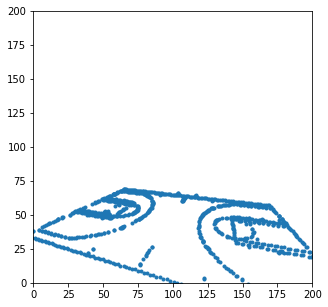

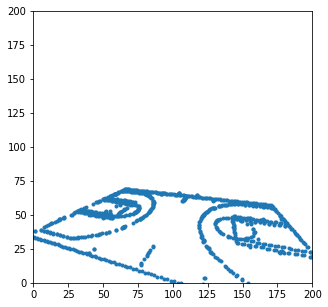

In [28]:
show_cam_view(X_w, dofs_cam, f, (100., 100.), (100, 100))
show_cam_view(X_w, dofs_cam_optim, f_optim, (100., 100.), (100, 100))